In [1]:
##########################################
# Fama French Factors
# April 2018
# Qingyi (Freda) Song Drechsler
##########################################

import pandas as pd
import numpy as np
import datetime as dt
import wrds
import psycopg2 
import matplotlib.pyplot as plt
from dateutil.relativedelta import *
from pandas.tseries.offsets import *
from scipy import stats

###################
# Connect to WRDS #
###################
conn=wrds.Connection()

Enter your WRDS username [Pro]:alfgarar
Enter your password:········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


In [3]:
###################
# CRSP Block      #
###################
# sql similar to crspmerge macro
crsp_m = conn.raw_sql("""
                      select a.permno, a.permco, a.date, b.shrcd, b.exchcd,
                      a.ret, a.retx, a.shrout, a.prc
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/1959' and '12/31/2017'
                      and b.exchcd between 1 and 3
                      """) 

# change variable format to int
crsp_m[['permco','permno','shrcd','exchcd']]=crsp_m[['permco','permno','shrcd','exchcd']].astype(int)

# Line up date to be end of month
crsp_m['date']=pd.to_datetime(crsp_m['date'])
crsp_m['jdate']=crsp_m['date']+MonthEnd(0)

# add delisting return
dlret = conn.raw_sql("""
                     select permno, dlret, dlstdt 
                     from crsp.msedelist
                     """)
dlret.permno=dlret.permno.astype(int)
dlret['dlstdt']=pd.to_datetime(dlret['dlstdt'])
dlret['jdate']=dlret['dlstdt']+MonthEnd(0)

crsp = pd.merge(crsp_m, dlret, how='left',on=['permno','jdate'])
crsp['dlret']=crsp['dlret'].fillna(0)
crsp['ret']=crsp['ret'].fillna(0)
crsp['retadj']=(1+crsp['ret'])*(1+crsp['dlret'])-1
crsp['me']=crsp['prc'].abs()*crsp['shrout'] # calculate market equity
crsp=crsp.drop(['dlret','dlstdt','prc','shrout'], axis=1)
crsp=crsp.sort_values(by=['jdate','permco','me'])

### Aggregate Market Cap ###
# sum of me across different permno belonging to same permco a given date
crsp_summe = crsp.groupby(['jdate','permco'])['me'].sum().reset_index()
# largest mktcap within a permco/date
crsp_maxme = crsp.groupby(['jdate','permco'])['me'].max().reset_index()
# join by jdate/maxme to find the permno
crsp1=pd.merge(crsp, crsp_maxme, how='inner', on=['jdate','permco','me'])
# drop me column and replace with the sum me
crsp1=crsp1.drop(['me'], axis=1)
# join with sum of me to get the correct market cap info
crsp2=pd.merge(crsp1, crsp_summe, how='inner', on=['jdate','permco'])
# sort by permno and date and also drop duplicates
crsp2=crsp2.sort_values(by=['permno','jdate']).drop_duplicates()

# keep December market cap
crsp2['year']=crsp2['jdate'].dt.year
crsp2['month']=crsp2['jdate'].dt.month
decme=crsp2[crsp2['month']==12]
decme=decme[['permno','date','jdate','me','year']].rename(columns={'me':'dec_me'})

### July to June dates
crsp2['ffdate']=crsp2['jdate']+MonthEnd(-6)
crsp2['ffyear']=crsp2['ffdate'].dt.year
crsp2['ffmonth']=crsp2['ffdate'].dt.month
crsp2['1+retx']=1+crsp2['retx']
crsp2=crsp2.sort_values(by=['permno','date'])

# cumret by stock
crsp2['cumretx']=crsp2.groupby(['permno','ffyear'])['1+retx'].cumprod()
# lag cumret
crsp2['lcumretx']=crsp2.groupby(['permno'])['cumretx'].shift(1)

# lag market cap
crsp2['lme']=crsp2.groupby(['permno'])['me'].shift(1)

# if first permno then use me/(1+retx) to replace the missing value
crsp2['count']=crsp2.groupby(['permno']).cumcount()
crsp2['lme']=np.where(crsp2['count']==0, crsp2['me']/crsp2['1+retx'], crsp2['lme'])

# baseline me
mebase=crsp2[crsp2['ffmonth']==1][['permno','ffyear', 'lme']].rename(columns={'lme':'mebase'})

# merge result back together
crsp3=pd.merge(crsp2, mebase, how='left', on=['permno','ffyear'])
crsp3['wt']=np.where(crsp3['ffmonth']==1, crsp3['lme'], crsp3['mebase']*crsp3['lcumretx'])

decme['year']=decme['year']+1
decme=decme[['permno','year','dec_me']]

# Info as of June
crsp3_jun = crsp3[crsp3['month']==6]

crsp_jun = pd.merge(crsp3_jun, decme, how='inner', on=['permno','year'])
crsp_jun=crsp_jun[['permno','date', 'jdate', 'shrcd','exchcd','retadj','me','wt','cumretx','mebase','lme','dec_me']]
crsp_jun=crsp_jun.sort_values(by=['permno','jdate']).drop_duplicates()

In [13]:
#######################################
### Merging CRSP and Compustat Data
#######################################

## We need to get ncusip (CRSP) and cusip (Comp) in our data
link_table = conn.raw_sql("""
                      select distinct ticker, comnam, a.permno, a.date, c.gvkey, c.iid, namedt, nameendt
                      from crsp.msf as a,
                      crsp.msenames as b,
                      comp.security as c
                      where a.date between '01/01/2019' and '12/31/2019'
                      and a.permno=b.permno
                      and b.ncusip=substr(c.cusip,1,8)
                      and c.excntry='USA'
                      and b.shrcd between 9.9 and 11.9
                      """) 

In [50]:
print(link_table.shape)
link_table.head()
link_table = link_table[link_table['date']>=link_table['namedt']]
link_table = link_table[link_table['date']<=link_table['nameendt']]
link_table['year'] = pd.DatetimeIndex(link_table['date']).year
clean_table = link_table[['comnam','ticker','permno','gvkey','iid','year','namedt','nameendt']].drop_duplicates()
clean_table.sort_values(by='comnam')
clean_table.apply(lambda x: len(x.unique()))
pd.pivot_table(clean_table,values='ticker',index='permno', aggfunc=pd.Series.nunique).sort_values(by='ticker')
clean_table[clean_table['permno']==81190]


(41769, 9)


,comnam,ticker,permno,gvkey,iid,year,namedt,nameendt
4801,VOLT INFORMATION SCIENCES INC,VOLT,81190.0,011213,01,2019,2019-09-09,2019-12-31
19983,VOLT INFORMATION SCIENCES INC,VISI,81190.0,011213,01,2019,2014-08-26,2019-09-08


In [15]:
# Create manual linktable: https://sites.google.com/site/ruidaiwrds/data/linking-crsp-and-compustat

link_table2 = conn.raw_sql("""
                          select distinct a.permno, a.date, abs(prc) as prc, c.gvkey, c.iid, shrcd
                          from crsp.msf as a
                          where a.datadate between '01/01/2019' and '12/31/2019'
                          left join crsp.msenames as b
                          on a.permno=b.permno
                          left join comp.security as c
                          on substr(c.cusip,1,8)=substr(b.ncusip,1,8)
                          left join (select distinct gvkey, datadate from comp.funda
                          where sale>0 or at>0) as d
                          on d.gvkey=c.gvkey
                          """)

ProgrammingError: (psycopg2.errors.SyntaxError) syntax error at or near "left"
LINE 5:                           left join crsp.msenames as b
                                  ^

[SQL: 
                          select distinct a.permno, a.date, abs(prc) as prc, c.gvkey, c.iid, shrcd
                          from crsp.msf as a
                          where a.datadate between '01/01/2019' and '12/31/2019'
                          left join crsp.msenames as b
                          on a.permno=b.permno
                          left join comp.security as c
                          on substr(c.cusip,1,8)=substr(b.ncusip,1,8)
                          left join (select distinct gvkey, datadate from comp.funda
                          where sale>0 or at>0) as d
                          on d.gvkey=c.gvkey
                          ]
(Background on this error at: http://sqlalche.me/e/f405)

In [27]:
print(crsp_m.shape)

# Remove all that are non-USA
crsp_m = crsp_m[crsp_m['excntry']=='USA']
print(crsp_m.shape)
# Remove all where ncusip or cusip are missing
print('Missing ncusip:',crsp_m['ncusip'].isna().sum())
print('Missing cusip:',crsp_m['cusip'].isna().sum())
# Remove all where shrcd not in (10 11)
print('shrcd not in (10 11):',(crsp_m['shrcd']<10).sum()+(crsp_m['shrcd']>11).sum())
crsp_m = crsp_m[crsp_m['shrcd']>=10]
crsp_m = crsp_m[crsp_m['shrcd']<=11]

crsp_m['year'] = pd.DatetimeIndex(crsp_m['date']).year

(3157135, 12)
(3157135, 12)
Missing ncusip: 0
Missing cusip: 0
shrcd not in (10 11): 0


In [62]:
#CLEAN UP DATA
crsp_m = crsp_m[crsp_m['vol']>=0]
crsp_clean = crsp_m[crsp_m['prc']>=0]

crsp_clean.head()

,permno,gvkey,iid,date,prc,vol,ret,ncusip,shrcd,cusip,excntry,year
28,10001.0,012994,01,1986-09-30,6.375,366.0,-0.003077,36720410,11.0,367204104,USA,1986
29,10001.0,012994,01,1986-10-31,6.625,362.0,0.039216,36720410,11.0,367204104,USA,1986
30,10001.0,012994,01,1986-11-28,7.000,312.0,0.056604,36720410,11.0,367204104,USA,1986
31,10001.0,012994,01,1986-12-31,7.000,312.0,0.015000,36720410,11.0,367204104,USA,1986
32,10001.0,012994,01,1987-01-30,6.750,399.0,-0.035714,36720410,11.0,367204104,USA,1987


In [59]:
#unique_crsp = crsp_m.drop_duplicates(subset =['permno','year'])

stock_count = pd.pivot_table(crsp_clean,values='permno',index='year', aggfunc=pd.Series.nunique)
stock_count['year'] = stock_count.index
stock_count['permno'][stock_count['year']<1968]=0

C:\Users\ruben\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


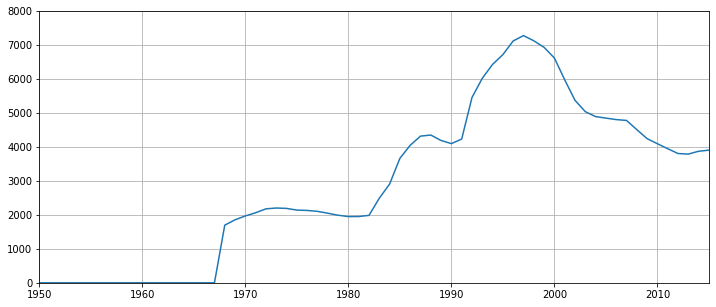

In [60]:
plt.figure(figsize=(12,5))
plt.axis([1950,2015,0,8000])
plt.plot(stock_count['permno'])
plt.grid()

In [40]:
unique_crsp[unique_crsp['prc']<=0]['prc'].value_counts()

-1.875000     315
-2.625000     315
-2.125000     314
-1.625000     307
-2.375000     297
             ... 
-27.744999      1
-4.780000       1
-17.315001      1
-8.530001       1
-75.595001      1
Name: prc, Length: 2998, dtype: int64

In [4]:
# #######################
# # CCM Block           #
# #######################
# ccm=conn.raw_sql("""
#                   select gvkey, lpermno as permno, linktype, linkprim, 
#                   linkdt, linkenddt
#                   from crsp.ccmxpf_linktable
#                   where substr(linktype,1,1)='L'
#                   and (linkprim ='C' or linkprim='P')
#                   """)

# ccm['linkdt']=pd.to_datetime(ccm['linkdt'])
# ccm['linkenddt']=pd.to_datetime(ccm['linkenddt'])
# # if linkenddt is missing then set to today date
# ccm['linkenddt']=ccm['linkenddt'].fillna(pd.to_datetime('today'))

# ccm1=pd.merge(comp[['gvkey','datadate','be', 'count']],ccm,how='left',on=['gvkey'])
# ccm1['yearend']=ccm1['datadate']+YearEnd(0)
# ccm1['jdate']=ccm1['yearend']+MonthEnd(6)

# # set link date bounds
# ccm2=ccm1[(ccm1['jdate']>=ccm1['linkdt'])&(ccm1['jdate']<=ccm1['linkenddt'])]
# ccm2=ccm2[['gvkey','permno','datadate','yearend', 'jdate','be', 'count']]

# # link comp and crsp
# ccm_jun=pd.merge(crsp_jun, ccm2, how='inner', on=['permno', 'jdate'])
# ccm_jun['beme']=ccm_jun['be']*1000/ccm_jun['dec_me']

# # select NYSE stocks for bucket breakdown
# # exchcd = 1 and positive beme and positive me and shrcd in (10,11) and at least 2 years in comp
# nyse=ccm_jun[(ccm_jun['exchcd']==1) & (ccm_jun['beme']>0) & (ccm_jun['me']>0) & (ccm_jun['count']>1) & ((ccm_jun['shrcd']==10) | (ccm_jun['shrcd']==11))]
# # size breakdown
# nyse_sz=nyse.groupby(['jdate'])['me'].median().to_frame().reset_index().rename(columns={'me':'sizemedn'})
# # beme breakdown
# nyse_bm=nyse.groupby(['jdate'])['beme'].describe(percentiles=[0.3, 0.7]).reset_index()
# nyse_bm=nyse_bm[['jdate','30%','70%']].rename(columns={'30%':'bm30', '70%':'bm70'})

# nyse_breaks = pd.merge(nyse_sz, nyse_bm, how='inner', on=['jdate'])
# # join back size and beme breakdown
# ccm1_jun = pd.merge(ccm_jun, nyse_breaks, how='left', on=['jdate'])


# # function to assign sz and bm bucket
# def sz_bucket(row):
#     if row['me']==np.nan:
#         value=''
#     elif row['me']<=row['sizemedn']:
#         value='S'
#     else:
#         value='B'
#     return value

# def bm_bucket(row):
#     if 0<=row['beme']<=row['bm30']:
#         value = 'L'
#     elif row['beme']<=row['bm70']:
#         value='M'
#     elif row['beme']>row['bm70']:
#         value='H'
#     else:
#         value=''
#     return value

# # assign size portfolio
# ccm1_jun['szport']=np.where((ccm1_jun['beme']>0)&(ccm1_jun['me']>0)&(ccm1_jun['count']>=1), ccm1_jun.apply(sz_bucket, axis=1), '')
# # assign book-to-market portfolio
# ccm1_jun['bmport']=np.where((ccm1_jun['beme']>0)&(ccm1_jun['me']>0)&(ccm1_jun['count']>=1), ccm1_jun.apply(bm_bucket, axis=1), '')
# # create positivebmeme and nonmissport variable
# ccm1_jun['posbm']=np.where((ccm1_jun['beme']>0)&(ccm1_jun['me']>0)&(ccm1_jun['count']>=1), 1, 0)
# ccm1_jun['nonmissport']=np.where((ccm1_jun['bmport']!=''), 1, 0)

# # store portfolio assignment as of June
# june=ccm1_jun[['permno','date', 'jdate', 'bmport','szport','posbm','nonmissport']]
# june['ffyear']=june['jdate'].dt.year

# # merge back with monthly records
# crsp3 = crsp3[['date','permno','shrcd','exchcd','retadj','me','wt','cumretx','ffyear','jdate']]
# ccm3=pd.merge(crsp3, 
#         june[['permno','ffyear','szport','bmport','posbm','nonmissport']], how='left', on=['permno','ffyear'])

# # keeping only records that meet the criteria
# ccm4=ccm3[(ccm3['wt']>0)& (ccm3['posbm']==1) & (ccm3['nonmissport']==1) & 
#           ((ccm3['shrcd']==10) | (ccm3['shrcd']==11))]

# ############################
# # Form Fama French Factors #
# ############################

# # function to calculate value weighted return
# def wavg(group, avg_name, weight_name):
#     d = group[avg_name]
#     w = group[weight_name]
#     try:
#         return (d * w).sum() / w.sum()
#     except ZeroDivisionError:
#         return np.nan

# # value-weigthed return
# vwret=ccm4.groupby(['jdate','szport','bmport']).apply(wavg, 'retadj','wt').to_frame().reset_index().rename(columns={0: 'vwret'})
# vwret['sbport']=vwret['szport']+vwret['bmport']

# # firm count
# vwret_n=ccm4.groupby(['jdate','szport','bmport'])['retadj'].count().reset_index().rename(columns={'retadj':'n_firms'})
# vwret_n['sbport']=vwret_n['szport']+vwret_n['bmport']

# # tranpose
# ff_factors=vwret.pivot(index='jdate', columns='sbport', values='vwret').reset_index()
# ff_nfirms=vwret_n.pivot(index='jdate', columns='sbport', values='n_firms').reset_index()

# # create SMB and HML factors
# ff_factors['WH']=(ff_factors['BH']+ff_factors['SH'])/2
# ff_factors['WL']=(ff_factors['BL']+ff_factors['SL'])/2
# ff_factors['WHML'] = ff_factors['WH']-ff_factors['WL']

# ff_factors['WB']=(ff_factors['BL']+ff_factors['BM']+ff_factors['BH'])/3
# ff_factors['WS']=(ff_factors['SL']+ff_factors['SM']+ff_factors['SH'])/3
# ff_factors['WSMB'] = ff_factors['WS']-ff_factors['WB']
# ff_factors=ff_factors.rename(columns={'jdate':'date'})

# # n firm count
# ff_nfirms['H']=ff_nfirms['SH']+ff_nfirms['BH']
# ff_nfirms['L']=ff_nfirms['SL']+ff_nfirms['BL']
# ff_nfirms['HML']=ff_nfirms['H']+ff_nfirms['L']

# ff_nfirms['B']=ff_nfirms['BL']+ff_nfirms['BM']+ff_nfirms['BH']
# ff_nfirms['S']=ff_nfirms['SL']+ff_nfirms['SM']+ff_nfirms['SH']
# ff_nfirms['SMB']=ff_nfirms['B']+ff_nfirms['S']
# ff_nfirms['TOTAL']=ff_nfirms['SMB']
# ff_nfirms=ff_nfirms.rename(columns={'jdate':'date'})

ProgrammingError: (psycopg2.errors.InsufficientPrivilege) permission denied for schema crsp_a_ccm

[SQL: 
                  select gvkey, lpermno as permno, linktype, linkprim, 
                  linkdt, linkenddt
                  from crsp.ccmxpf_linktable
                  where substr(linktype,1,1)='L'
                  and (linkprim ='C' or linkprim='P')
                  ]
(Background on this error at: http://sqlalche.me/e/f405)